# Safety

## Decide if $(d, cap)$ is safe in a given state
Given a state $s$ we want to decide whether there exists a strategy $\sigma$ such that all runs that follow $\sigma$ and that start with the initial resource value $d$ in $s$ will be safe in a system with capacity $cap$. By safe here we mean that the resource will never be depleted.

### MinInitCons
The function $\mathrm{MinInitCons}[\mathcal{M}]: S \to \mathbb{N} \cup \{\infty\}$ computes the minimal consumption until a reload state is reached.

In [1]:
#%%writefile safety.py
from math import inf

class minInitCons:
    """Compute function minInitCons for given consMDP `m`.

    minInitCons_m: S -> N ∪ {∞} returns for given `s` the minimum
    amount `s_m` of resource such that there exists a strategy that
    guarantees reachability of some reload state from s consuming
    at most `s_m`.

    Typical use:
    MI = minInitCons(mdp)
    MI.get_values()
    """

    def __init__(self, mdp):
        self.mdp     = mdp
        self.states  = mdp.num_states
        self.values  = None

    def action_value(self, a):
        non_reload_succs = [self.values[succ] for succ in a.distr.keys()
                   if not self.mdp.is_reload(succ)]
        a_v = 0 if len(non_reload_succs) == 0 else max(non_reload_succs)
        return a_v + a.cons

    def fixpoint(self):
        """Computes the functional F.

        The functionals compute for each state `s` the maximum
        energy needed to reach a reload state from `s`.
        """
        values = [inf for s in range(self.states)]
        self.values = values

        # iterate until a fixpoint is reached or for at most |S| steps
        iterate = True
        c = self.states      
        while iterate and c > 0:
            iterate = False
            c -= 1

            for s in range(self.states):
                current_v = values[s]
                actions = self.mdp.actions_for_state(s)
                # candidate_v is now the minimum over action values
                candidate_v = min([self.action_value(a) for a in actions])

                # F is monotonicly decreasing, # check for decrease only
                if candidate_v < current_v:
                    values[s] = candidate_v
                    iterate = True

        self.values = values


    def get_values(self, recompute=False):
        """Return (and compute) minInitCons list for self.m.
        
        When called for the first time, it computes the values.
        Recomputes the values if requested by `recompute`.
        """
        if self.values is None or recompute:
            self.fixpoint()
        return self.values

In [2]:
%run Kucera-example.ipynb

In [3]:
MI = minInitCons(m)
MI.get_values()

[0, 3, 2, 0, 3, 9, 14, 1, 1, 0, 5, 1, 1]

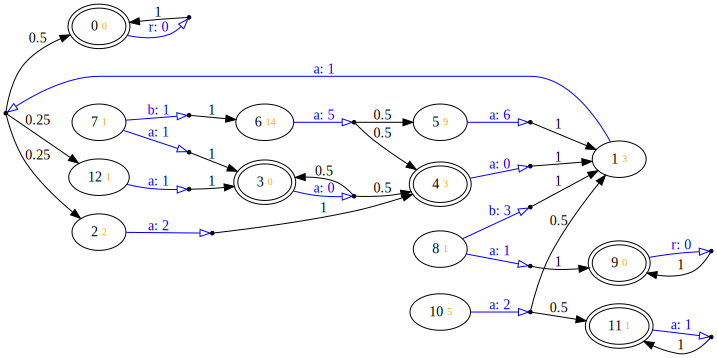

In [4]:
m.show("M")

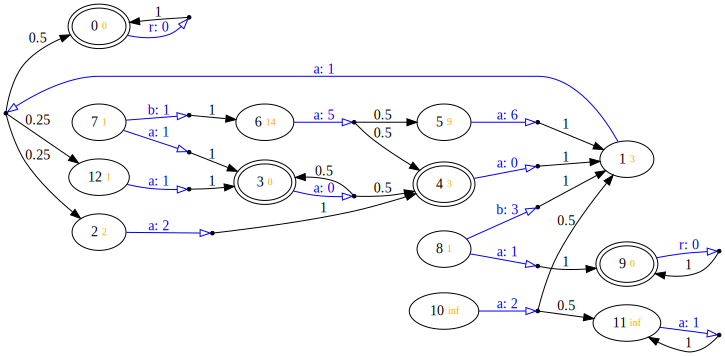

In [5]:
m.unset_reload(11)
m.show("M")

In [6]:
print(MI.get_values())
MI2 = minInitCons(m)
MI2.get_values()

[0, 3, 2, 0, 3, 9, 14, 1, 1, 0, 5, 1, 1]


[0, 3, 2, 0, 3, 9, 14, 1, 1, 0, inf, inf, 1]

## Example of incorrectness of the least fixpoint algorithm bounded by $|S|$ steps

In [7]:
from safety_incorrect import minInitCons_least

In [8]:
m = consMDP.ConsMDP()
m.new_state(True)
m.new_states(2)
m.add_action(0, {0:1}, "", 0)
m.add_action(1, {0:1}, "a", 1000)
m.add_action(1, {2:1}, "b", 1)
m.add_action(2, {1:1}, "b", 1)
MI = minInitCons_least(m)
MI.get_values()

[0, inf, 6]

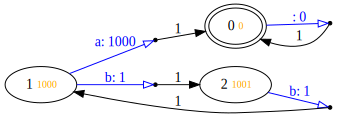

In [9]:
m.show("M")